# 1- Imports

In [2]:
## Essenciais
import pandas as pd
import numpy  as np

### Save
import pickle as pkl

### Plot gráfico
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn           as sns

### Machine Learning
# Métricas
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics         import f1_score, confusion_matrix, recall_score 
# Modelos
from sklearn.ensemble        import RandomForestClassifier
from xgboost                 import XGBClassifier
from sklearn.linear_model    import RidgeClassifierCV, LogisticRegressionCV


### Lib proprietária
from RSLib.nuter import preparacao_dados as nt
from RSLib.nuter import ML_process as mlp


# Funções auxiliares | Configurações

In [3]:
### Notações científicas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Avisos
import warnings
warnings.simplefilter("ignore")

In [4]:
def cv_result(rfc, xgbc, rdgc, lrgc, xten, yte):
    # predict
    y_pred_rf  = rfc.predict( xten )
    y_pred_xgb = xgbc.predict( xten )
    y_pred_rc  = rdgc.predict( xten )
    y_pred_lr  = lrgc.predict( xten )

    # Confusion Matrix
    conf_matrx( y_pred_rf, y_pred_xgb, y_pred_rc, y_pred_lr, yte )

    # F1 Score data frame 
    result = pd.DataFrame({
    'Random_Forest'           : f1_score( yte, y_pred_rf, average='binary' , pos_label = 1 ),
    'XGBoost'                 : f1_score( yte, y_pred_xgb, average='binary', pos_label = 1 ),
    'Ridge_Classifier'        : f1_score( yte, y_pred_rc, average='binary' , pos_label = 1 ),
    'Logistic_Reg' : f1_score( yte, y_pred_lr, average='binary' , pos_label = 1 )
    
    }, index = [0])

    return result


def conf_matrx( y_pred_rf, y_pred_xgb, y_pred_rc, y_pred_lr, yte  ):
    # Configurações de tamanho de plot
    sns.set( rc={'figure.figsize' : (20,8)} )

    #divisão em specs(quadros dentro do mesmo conjunto de plot gráfico)
    specs = GridSpec(2,2)

    ###--- Random Forest ---###
    plt.subplot(specs[0,0])
    #Matriz de confusão
    cf_matrix = confusion_matrix(yte, y_pred_rf)
    sns.heatmap(cf_matrix, annot = True, fmt = '.1f' )
    plt.title( 'Random Forest Classifier' )

    ###--- Random Forest ---###
    plt.subplot(specs[0,1])
    #Matriz de confusão
    cf_matrix = confusion_matrix(yte, y_pred_xgb)
    sns.heatmap(cf_matrix, annot = True, fmt = '.1f' )
    plt.title( 'XGBoost Classifier' )

    ###--- Random Forest ---###
    plt.subplot(specs[1,0])
    #Matriz de confusão
    cf_matrix = confusion_matrix(yte, y_pred_rc)
    sns.heatmap(cf_matrix, annot = True, fmt = '.1f' )
    plt.title( 'Ridge Classifier' )

    ###--- Random Forest ---###
    plt.subplot(specs[1,1])
    #Matriz de confusão
    cf_matrix = confusion_matrix(yte, y_pred_lr)
    sns.heatmap(cf_matrix, annot = True, fmt = '.1f' )
    plt.title( 'Logistic Regressor' )

In [5]:
def fine_T():   
    ### Escolha dos parâmetros a serem testados
    param = {
        'n_estimators'      : [1000, 2000],
        'max_depth'        : [1, 6, 50],
        'learning_rate'    : [0.001, 0.6, 1],
        'min_child_weight' : [1, 6, 20],
        'subsample'        : [0.1, 0.6, 1],
        'colsample_bytree' : [0.1, 0.6, 1]

    }

    ### Modelo
    xgb = XGBClassifier()

    ### GridSearch
    gs_xgb = GridSearchCV(
        estimator  = xgb,
        param_grid = param,
        cv         = StratifiedKFold( n_splits = 2), 
        scoring    = 'f1_weighted',
        verbose    = 1

    )
    return gs_xgb

def teste_modelo( x, y, model, cv = 5):
    scores = cross_val_score(
        model, x, y, cv = cv, scoring = 'f1_macro', 
    ) 

    ypred = model.predict( x )
    cf_matrix = confusion_matrix(y, ypred)
    
    return scores, cf_matrix    

# 2- Importação dos dados

In [6]:
data_raw = pkl.load( open( '../data/pickle/clean_data.sav', 'rb' ) )

In [8]:
### Separando DF em variáveis preditoras e variável resposta 
x = data_raw.drop( columns = 'isFraud' )
y = data_raw.isFraud

In [9]:
### Feature Eng.
x = nt.feature_eng( x )

In [10]:
pkl.dump( x, open( '../data/pickle/x.sav', 'wb' ) )
pkl.dump( y, open( '../data/pickle/y.sav', 'wb' ) )

In [22]:
x = pkl.load( open( '../data/pickle/x.sav', 'rb' ) )

# 4- Separação dos dados em: Treino validação e teste

In [11]:
### Separando conjuntos
# Total em: Treino e validação
xtr, xte_val, ytr, yte_val = train_test_split( x, y, train_size = 0.6, stratify = y  )
# Validaçao em: Validação e teste   
xte, xval, yte, yval = train_test_split( xte_val, yte_val, train_size = 0.8, stratify = yte_val )

### Salvando treino, validação e teste
pkl.dump( xtr, open( '../data/pickle/xtr.sav', 'wb' ) )
pkl.dump( ytr, open( '../data/pickle/ytr.sav', 'wb' ) )
pkl.dump( xte, open( '../data/pickle/xte.sav', 'wb' ) )
pkl.dump( yte, open( '../data/pickle/yte.sav', 'wb' ) )
pkl.dump( xval, open( '../data/pickle/xval.sav', 'wb' ) )
pkl.dump( yval, open( '../data/pickle/yval.sav', 'wb' ) )

# 3- Preparação dos dados ( Normalização ) 

In [12]:
xtrn, rs, mms = nt.rescaling( xtr )
xten, rs, mms = nt.rescaling( xte )

pkl.dump( rs, open( '../data/models/rs.sav', 'wb' ) )
pkl.dump( mms, open( '../data/models/rs.sav', 'wb' ) )



# 4- Teste de modelos ( XGBoost selecionado )

#### Random Forest

In [4]:
### Definição e treino do modelo
rfc = RandomForestClassifier( n_jobs = -1 )
rfc.fit( xtrn, ytr )

RandomForestClassifier(n_jobs=-1)

#### XGBoost

In [38]:
xgbc = XGBClassifier( n_jobs = -1 )
xgbc.fit( xtrn, ytr )

### Recall Score do modelo
y_predict = xgbc.predict( xten )
recall_score( yte, y_predict, average = 'binary', pos_label = 1 )

0.9661339421613394

#### Ridge Classifier

In [12]:
rdgc = RidgeClassifierCV()
rdgc.fit( xtrn, ytr )

#### Logistic Reg Classifier

In [ ]:
lrgc = LogisticRegressionCV()
lrgc.fit( xtrn, ytr )

#### Save dos modelos

In [11]:
pkl.dump( rfc, open( '../data/models/rando_forest.sav', 'wb' ) )
pkl.dump( xgbc, open( '../data/models/xgboost.sav', 'wb' ) )
pkl.dump( rfc, open( '../data/models/ridge_classif.sav', 'wb' ) )
pkl.dump( lrgc, open( '../data/models/logistic_reg.sav', 'wb' ) )


#### Resultados

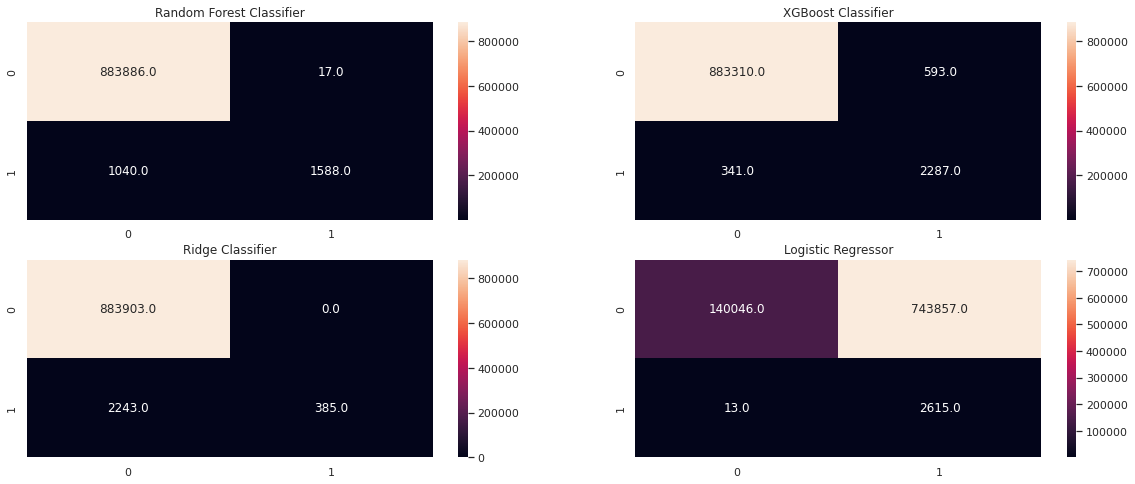

In [27]:
result = cv_result(rfc, xgbc, rdgc, lrgc, xten, yte)

In [ ]:
result = cv_result(rfc, xgbc, rdgc, lrgc, xten, yte)
pkl.dump( result, open( '../data/pickle/result_models.sav', 'wb' ) )


    Frente a demora no treino e os resultados ruins, serão descartados Ridge Classifier e Logistic Regression
    Pela maior pontuação e análise da matriz de confusão, será utilizado o XGBoost

# 5- Fine Tuning

In [4]:
### Escolha dos parâmetros a serem testados
param = {
    'n_estimators'      : [1000, 2000],
    'max_depth'        : [1, 6, 50],
    'learning_rate'    : [0.001, 0.6, 1],
    'min_child_weight' : [1, 6, 20],
    'subsample'        : [0.1, 0.6, 1],
    'colsample_bytree' : [0.1, 0.6, 1]

}

### Modelo
xgb = XGBClassifier()

### GridSearch
gs_xgb = GridSearchCV(
    estimator  = xgb,
    param_grid = param,
    cv         = StratifiedKFold( n_splits = 2), 
    scoring    = 'f1_weighted',
    verbose    = 1

)

In [14]:
### Separando uma pequena amostra estratificada para não usar o GridSearch em uma amostra grande 
xfit, nan, y_fit, nan = train_test_split( xtrn, ytr, train_size = 0.01, stratify = ytr  )

### Setando parâmetros e treinando modelo
gs_xgb = fine_T()
gs_xgb.fit( xfit, y_fit );

In [10]:
### Salvando melhores parâmetros 
best_params = gs_xgb.best_params_

#Fazendo bkp do modelo treinado e dos melhores parâmetros
pkl.dump( best_params, open( '../data/models/best_params.sav', 'wb' ) )
pkl.dump( gs_xgb, open( '../data/models/xgb_fineT.sav', 'wb' ) )


# CheckPoint

In [7]:
### Carga dos dados
xtr = pkl.load( open( '../data/pickle/xtr.sav', 'rb' ) )
xte = pkl.load( open( '../data/pickle/xte.sav', 'rb' ) )

ytr = pkl.load( open( '../data/pickle/ytr.sav', 'rb' ) )
yte = pkl.load( open( '../data/pickle/yte.sav', 'rb' ) )

### Normalização
xtrn, rs, mms = nt.rescaling( xtr )
xten, rs, mms = nt.rescaling( xte )

### Melhores Parâmetros
best_params = pkl.load( open( '../data/models/best_params.sav', 'rb' ) )
params      = pkl.load( open( '../data/models/params.sav', 'rb' ) )

x_val = pkl.load( open( '../data/pickle/xval.sav', 'rb' ) )
y_val = pkl.load( open( '../data/pickle/yval.sav', 'rb' ) )

# 6- Feature Selection

    Com base na análise gráfica da importância das features, serão selecionadas as 6 primeiras features para treinar o modelo

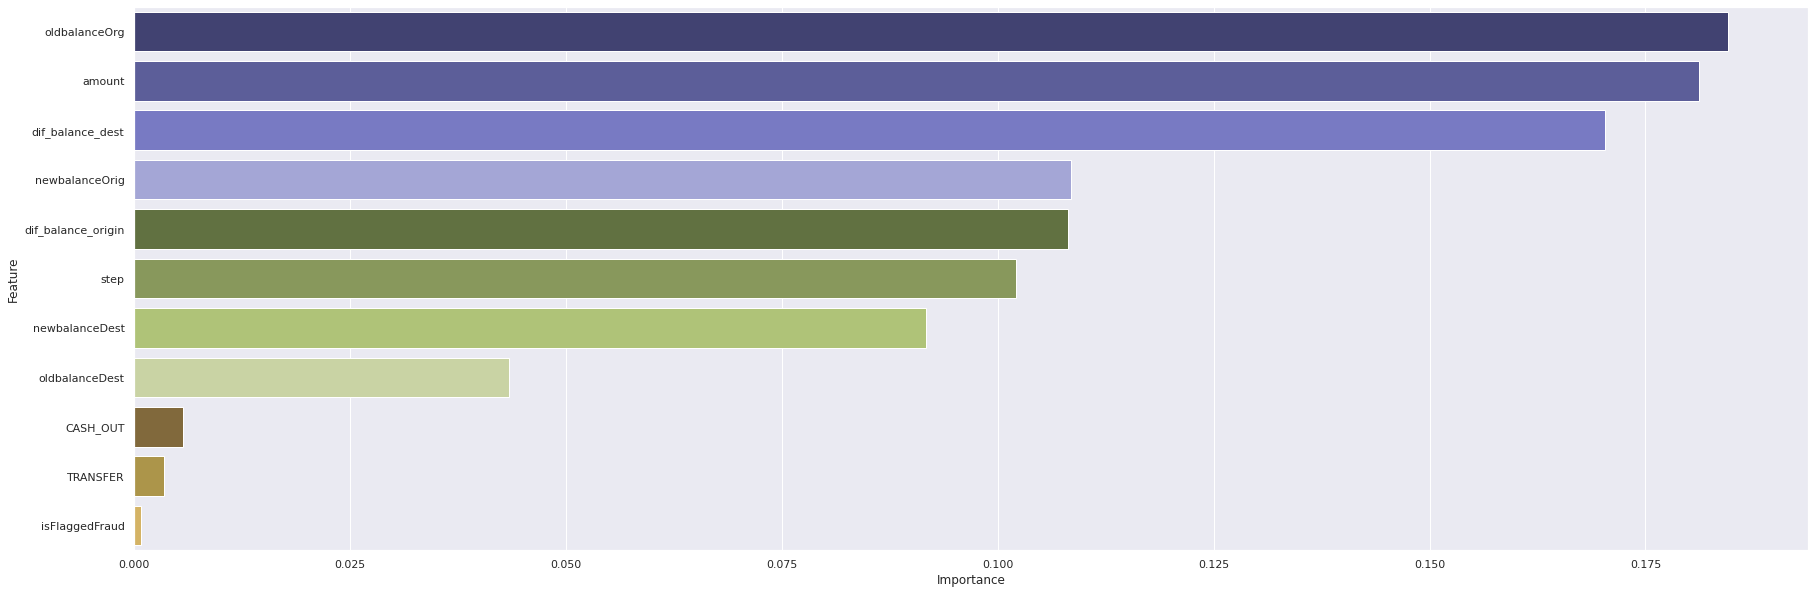

In [14]:
### Chamando função para criar DF com o nome e a importância das features
df_importance = mlp.feature_importance( xtrn, ytr )

### Plotagem do gráfico com informações referentes a importância das features
sns.set( rc={'figure.figsize' : (30,10)} )
sns.barplot(
    data    = df_importance, 
    x       = 'Importance', 
    y       = 'Feature',
    palette = 'tab20b'
);

In [15]:
### Criando variável a ser usada para selecionar as colunas que alimentarão o modelo
cols_selected = list( df_importance['Feature'].head(8) )
pkl.dump( cols_selected, open( '../data/pickle/cols_selected.sav', 'wb' ) )

# 7- Implementação e testes do modelo

## 7.1 Testes de Tuning e Feature Selection

### Sem upgrades e sem normalização

Média Score F1 Macro: 0.9453041875478384


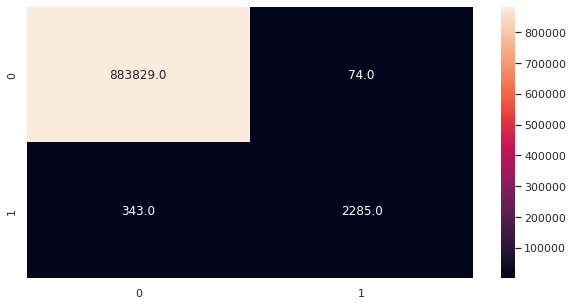

In [109]:
model = XGBClassifier().fit(xtr.drop( columns = ['type', 'nameOrig', 'nameDest'] ), ytr)
scores, cf_matrix = teste_modelo( xte.drop( columns = ['type', 'nameOrig', 'nameDest'] ), yte, model )

print( f'Média Score F1 Macro: {scores.mean()}' )

sns.heatmap(
    cf_matrix, annot = True, fmt = '.1f' 
);

### Sem upgrades (Best Score)

Média Score F1 Macro: 0.9980874014236256


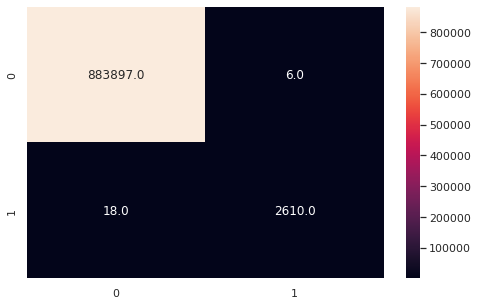

In [27]:
model = XGBClassifier().fit(xtrn, ytr)
scores, cf_matrix = teste_modelo( xten, yte, model )

print( f'Média Score F1 Macro: {scores.mean()}' )

sns.set( rc = {'figure.figsize' : ( 8,5 )} )
sns.heatmap(
    cf_matrix, annot = True, fmt = '.1f' 
);

### Sem upgrades e com undersampling

In [104]:
x_under = xtrn.reset_index( drop = True )
y_under = ytr.reset_index( drop = True )

x_tr_tot = pd.concat( [x_under, y_under], axis = 1 )

In [105]:
aux      = x_tr_tot[x_tr_tot.isFraud == 0].head(30000)
aux1     = x_tr_tot[x_tr_tot.isFraud == 1]
aux1.drop(columns = ['isFraud'], axis = 1, inplace = True )
x_tr_tot = pd.concat( [aux, aux1], axis = 0 )
x_tr_tot = x_tr_tot.fillna(1)

x_under = x_tr_tot.drop(  columns = ['isFraud'])
y_under = x_tr_tot.isFraud

Média Score F1 Macro: 0.9512562425033162


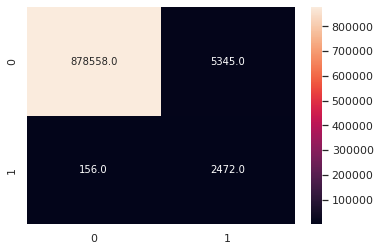

In [106]:
model = XGBClassifier().fit(x_under, y_under)
scores, cf_matrix = teste_modelo( xten, yte, model )

print( f'Média Score F1 Macro: {scores.mean()}' )

sns.heatmap(
    cf_matrix, annot = True, fmt = '.1f' 
);

### Sem upgrades e feature Selection

Média Score F1 Macro: 0.9469486163165252


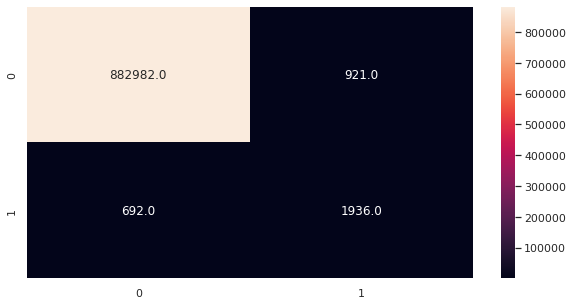

In [106]:
model = XGBClassifier().fit(xtrn[cols_selected], ytr)
scores, cf_matrix = teste_modelo( xten[cols_selected], yte, model )

print( f'Média Score F1 Macro: {scores.mean()}' )

sns.heatmap(
    cf_matrix, annot = True, fmt = '.1f' 
);

### Com Fine Tuning

In [ ]:
model = XGBClassifier(
    colsample_bytree = 0.6,
    learning_rate    = 0.001,
    max_depth        = 6,
    min_child_weight = 1,
    n_estimators     = 2000,
    subsample        = 1
).fit(xtrn, ytr)


Média Score F1 Macro: 0.9174051072409066
Recall score: 0.478310502283105


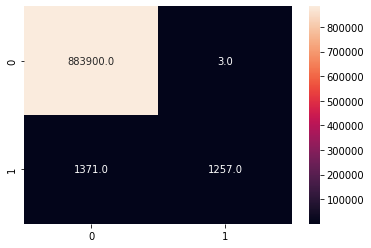

In [43]:
### Calculando score usando Cross validation e criando matrix de confusão
scores, cf_matrix = teste_modelo( xten, yte, model )
print( f'Média Score F1 Macro: {scores.mean()}' )

### Calculando Recall score
y_pred = model.predict( xten )
rc_s   = recall_score(yte, y_pred, average='binary' , pos_label = 1) 
print( f'Recall score: {rc_s}' )

### Plotando Matrix de confusão
sns.heatmap(
    cf_matrix, annot = True, fmt = '.1f' 
);

### Alterando Fine Tuning

Média Score F1 Macro: 0.9180225867809849


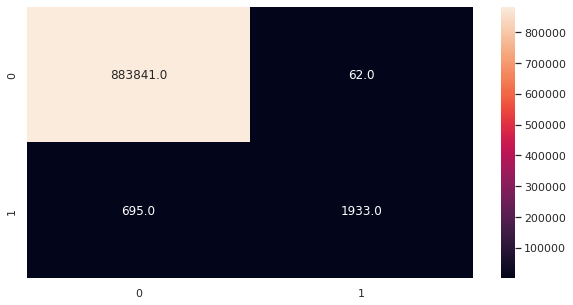

In [87]:
model = XGBClassifier(
    colsample_bytree = 1,
    learning_rate    = 0.001,
    max_depth        = 6,
    min_child_weight = 1,
    n_estimators     = 2000,
    subsample        = 0.6
).fit(xtrn, ytr)
scores, cf_matrix = teste_modelo( xten, yte, model )

print( f'Média Score F1 Macro: {scores.mean()}' )

sns.heatmap(
    cf_matrix, annot = True, fmt = '.1f' 
);

### Com Fine Tuning e Feature Selection

Média Score F1 Macro: 0.8847641085161143


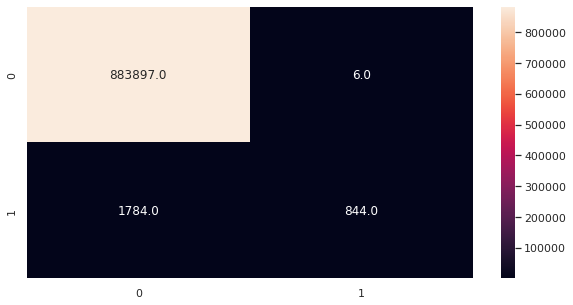

In [86]:
model = XGBClassifier(
    colsample_bytree = 0.6,
    learning_rate    = 0.001,
    max_depth        = 6,
    min_child_weight = 1,
    n_estimators     = 2000,
    subsample        = 1
).fit(xtrn[cols_selected], ytr)

scores, cf_matrix = teste_modelo( xten[cols_selected], yte, model )

print( f'Média Score F1 Macro: {scores.mean()}' )

sns.heatmap(
    cf_matrix, annot = True, fmt = '.1f' 
);

### Adicionando probabilidades geradas pelo Ridge Classifier

In [27]:
rdgc = RidgeClassifierCV()
rdgc.fit( xtrn, ytr )

rgcte_proba = rdgc._predict_proba_lr( xtrn )
xtr_proba = xtrn.copy()
xtr_proba['proba'] = rgcte_proba[:,1]
model = XGBClassifier().fit(xtrn, ytr)
y_predict = model.predict( xten )

model = RidgeClassifierCV().fit(xten, y_predict)
rgcte_proba = model._predict_proba_lr( xten )
xte_proba = xten.copy()
xte_proba['proba'] = rgcte_proba[:,1]
model = XGBClassifier().fit(xtr_proba, ytr)


Média Score F1 Macro: 0.9465068882181983


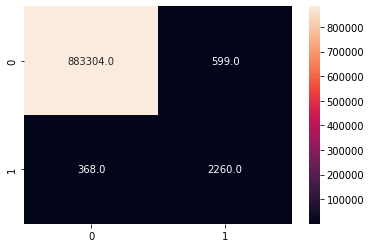

In [36]:
scores, cf_matrix = teste_modelo( xte_proba, yte, model )

print( f'Média Score F1 Macro: {scores.mean()}' )

sns.heatmap(
    cf_matrix, annot = True, fmt = '.1f' 
);

## 7.2- Deploy

In [17]:
### Concatenando valores de treino e teste
x_trn = pd.concat( [xtrn, xten] )
y_tr = pd.concat( [ytr, yte] )


In [18]:
### Treinando modelo com dados globais
model = XGBClassifier().fit( x_trn.drop( columns = 'isFlaggedFraud' ), y_tr )

In [27]:
### Normalização dos dados de validação
x_valn, rs, mms = nt.rescaling( xval, rs, mms )
x_valn.drop( columns = 'isFlaggedFraud', inplace = True )


0.9954337899543378


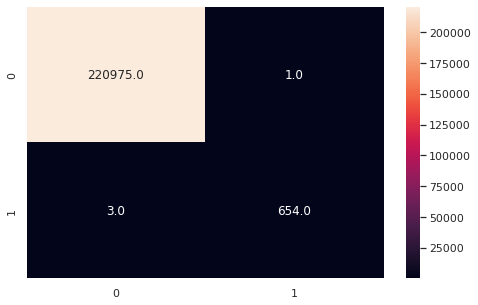

In [35]:
### Fazendo previsões com o modelo já treinado em quase toda base de dados
y_pred = model.predict( x_valn )
### Medindo a acurácia com ênfase na resposta de interesse (IsFraud == 1)
print( recall_score( yval, y_pred, average='binary' , pos_label = 1 ) )

### Plotando matriz de confusão 
cf_matrix = confusion_matrix(yval, y_pred)
sns.set( rc = {'figure.figsize' : (8,5)} )
sns.heatmap(
    cf_matrix, 
    annot = True,
    fmt = '.1f'
);


In [33]:
### Salvando o modelo
pkl.dump( model, open( '../data/models/xgb_final.sav', 'wb' ) )
pkl.dump( y_pred, open( '../data/pickle/y_pred.sav', 'wb' ) )

# CheckPoint

In [16]:
model  = pkl.load( open( '../data/models/xgb_final.sav', 'rb' ) )
x_val  = pkl.load( open( '../data/pickle/xval.sav', 'rb' ) )
y_val  = pkl.load( open( '../data/pickle/yval.sav', 'rb' ) )

# 8- Métricas de negócio

    Partindo do pressuposto que o método de análise atual dá como resultado a variável 'isFlaggedFraud', todos as métricas de negócio tomarão como base ela.

In [5]:
expeted_r = pd.DataFrame()

expeted_r['base']    = x_val.isFlaggedFraud.reset_index( drop = True )
expeted_r['y_pred']      = y_pred
expeted_r['y_real']      = y_val.reset_index( drop = True )
expeted_r['valor']       = x_val.amount.reset_index( drop = True )
expeted_r['er_modelo'] = expeted_r.apply( lambda x : x['valor'] if ( x['y_real'] == 1 ) & ( x['y_pred'] == 0 ) else 0, axis = 1 )
expeted_r['er_base'] = expeted_r.apply( lambda x : x['valor'] if ( x['y_real'] == 1 ) & ( x['base'] == 0 ) else 0, axis = 1 )

Adicionar erros:
- Falso positivo---=---=---=---=---=---=-[x]
- Falso negativo---=---=---=---=---=---=-[ ]
- ?Estipular valor para falsos negativos [ ]